In [31]:
import pandas as pd
import numpy as np

loans=pd.read_csv("../course_3_data/lending-club-data.csv")

/home/prachi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (19,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans.drop('bad_loans',axis=1,inplace=True)
target = 'safe_loans'
loans = loans[features + [target]]

In [33]:
loans=pd.get_dummies(loans)

In [34]:
train_idx=pd.read_json("../course_3_data/module-8-assignment-2-train-idx.json")
test_idx=pd.read_json("../course_3_data/module-8-assignment-2-test-idx.json")

In [35]:
train_data=loans.iloc[train_idx[0]]
test_data=loans.iloc[test_idx[0]]

In [36]:
safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]
# Undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(frac=percentage)
loans_data = risky_loans_raw.append(safe_loans)

In [37]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
#     print(labels_in_node,data_weights)
    # Sum the weights of all entries with label +1
    total_weight_positive = sum(data_weights[labels_in_node == +1])
    
    # Weight of mistakes for predicting all -1's is equal to the sum above
    ### YOUR CODE HERE
    weighted_mistakes_all_negative = total_weight_positive
    
    # Sum the weights of all entries with label -1
    ### YOUR CODE HERE
    total_weight_negative = sum(data_weights[labels_in_node == -1])
    
    # Weight of mistakes for predicting all +1's is equal to the sum above
    ### YOUR CODE HERE
    weighted_mistakes_all_positive = total_weight_negative
    
    # Return the tuple (weight, class_label) representing the lower of the two weights
    #    class_label should be an integer of value +1 or -1.
    # If the two weights are identical, return (weighted_mistakes_all_positive,+1)
    ### YOUR CODE HERE
#     print(weighted_mistakes_all_negative,weighted_mistakes_all_positive)
    if weighted_mistakes_all_negative>weighted_mistakes_all_positive:
        return (weighted_mistakes_all_positive,+1)
    
    elif weighted_mistakes_all_negative==weighted_mistakes_all_positive:
        return (weighted_mistakes_all_positive,+1)
    else:
        return (weighted_mistakes_all_negative,-1) 

In [38]:
# If the data is identical in each feature, this function should return None

def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))

    # Loop through each feature to consider splitting on that feature
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        ## YOUR CODE HERE
        left_data_weights = data_weights[data[feature] == 0]
        right_data_weights = data_weights[data[feature] == 1]
                    
        # DIFFERENT HERE
        # Calculate the weight of mistakes for left and right sides
        ## YOUR CODE HERE
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(left_split[target],left_data_weights)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(right_split[target],right_data_weights)
        
        # DIFFERENT HERE
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) / [total weight of all data points]
        ## YOUR CODE HERE
        error = (left_weighted_mistakes+right_weighted_mistakes)/len(data_weights)
        
        # If this is the best error we have found so far, store the feature and the error
        if error < best_error:
            best_feature = feature
            best_error = error
    
    # Return the best feature we found
    return best_feature

In [39]:
def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    # Store the predicted class (1 or -1) in leaf['prediction']
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    leaf['prediction'] = best_class ## YOUR CODE HERE
    
    return leaf

In [40]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    print("--------------------------------------------------------------------")
    print("Subtree, depth = %s (%s data points)." % (current_depth, len(target_values)))
    
    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print("Stopping condition 1 reached."  )              
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print("Stopping condition 2 reached." )               
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print("Reached maximum depth. Stopping for now.")
        return create_leaf(target_values, data_weights)
    
    # If all the datapoints are the same, splitting_feature will be None. Create a leaf
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    remaining_features.remove(splitting_feature)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print("Split on feature %s. (%s, %s)" % (\
              splitting_feature, len(left_split), len(right_split)))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print("Creating leaf node.")
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print("Creating leaf node.")
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

In [41]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

In [42]:
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print("At leaf, predicting %s" % tree['prediction'])
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print("Split on %s = %s" % (tree['splitting_feature'], split_feature_value))
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

In [43]:
def evaluate_classification_error(tree, data):
    # Apply the classify(tree, x) to each row in your data
    prediction=[]
    for i in range(len(data)):
        prediction.append(classify(tree,data.iloc[i]))
        
    # Once you've made the predictions, calculate the classification error
    return (prediction != data[target]).sum() / float(len(data))

In [44]:
features=list(train_data.columns[1:])
train_data


,safe_loans,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months,...,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year
1,-1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6,-1,0,0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
7,-1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
10,-1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
12,-1,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122572,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
122575,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
122588,1,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
122599,1,0,0,0,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0


In [45]:
# Assign weights
example_data_weights = np.array([1.] * 10 + [0.]*(len(train_data) - 20) + [1.] * 10)
# Train a weighted decision tree model.
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, features, target,
                         example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature home_ownership_RENT. (20514, 16710)
--------------------------------------------------------------------
Subtree, depth = 2 (20514 data points).
Split on feature grade_F. (19613, 901)
--------------------------------------------------------------------
Subtree, depth = 3 (19613 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (901 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (16710 data points).
Split on feature grade_D. (13315, 3395)
--------------------------------------------------------------------
Subtree, depth = 3 (13315 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 3 (3395 data points).
Stoppin

In [46]:
evaluate_classification_error(small_data_decision_tree_subset_20, train_data)

0.48124865678057166

In [47]:
from math import log
from math import exp

def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = np.array([1.]*len(data))
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in range(num_tree_stumps):
#         print(alpha)
        print('=====================================================')
        print('Adaboost Iteration %d' % t)
        print('=====================================================')        
        # Learn a weighted decision tree stump. Use max_depth=1
        tree_stump = weighted_decision_tree_create(data, features, target, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        print(tree_stump)
        # Make predictions
        predictions=[]
        for i in range(len(data)):
            predictions.append(classify(tree_stump,data.iloc[i]))

        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        is_correct = predictions == target_values
        is_wrong   = predictions != target_values
        
        # Compute weighted error
        # YOUR CODE HERE
        
        
        weighted_error = np.sum(alpha[is_wrong])/np.sum(alpha)
#         weighted_error=weighted_error[0]/sum(alpha)
        # Compute model coefficient using weighted error
        # YOUR CODE HERE
        
        er=(1-weighted_error)/weighted_error
        
        weight = 0.5*log(er)
        weights.append(weight)
        
        # Adjust weights on data point
        adjustment = is_correct.apply(lambda is_correct : exp(-weight) if is_correct else exp(weight))
        
        # Scale alpha by multiplying by adjustment
        # Then normalize data points weights
        ## YOUR CODE HERE 
        alpha=alpha*adjustment
    
    return weights, tree_stumps

In [48]:
stump_weights,tree_stumps=adaboost_with_tree_stumps(train_data,features,target,10)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
{'is_leaf': False, 'prediction': None, 'splitting_feature': 'term_ 36 months', 'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1}, 'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1}}
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth

In [49]:
stump_weights

[0.15802933659263743,
 0.1768236329363596,
 0.0931188897118565,
 0.07288885525865706,
 0.06706306914162646,
 0.0645691696162263,
 0.05456055779184845,
 0.0435109367337119,
 0.028988711500360906,
 0.019333438170587768]

In [50]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = np.array([0.]*len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions=[]
        for j in range(len(data)):
            predictions.append(classify(tree_stump,data.iloc[j]))

        # Accumulate predictions on scores array
        # YOUR CODE HERE

        scores=scores+np.dot(predictions,stump_weights[i])
    
         
    return list(map(lambda x:+1 if x>0 else -1,scores))

In [51]:
predict_adaboost(stump_weights,tree_stumps,train_data)

[-1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -

In [53]:
stump_weights,tree_stumps=adaboost_with_tree_stumps(train_data,features,target,30)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
{'is_leaf': False, 'prediction': None, 'splitting_feature': 'term_ 36 months', 'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1}, 'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1}}
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth

Adaboost Iteration 11
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_B. (26858, 10366)
--------------------------------------------------------------------
Subtree, depth = 2 (26858 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (10366 data points).
Reached maximum depth. Stopping for now.
{'is_leaf': False, 'prediction': None, 'splitting_feature': 'grade_B', 'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1}, 'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1}}
Adaboost Iteration 12
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_F. (35512, 1712)
--------------------------------------------------------------------
Subtree, depth = 2 (35512 data points).
Reached maximum depth. Stopping f

Split on feature grade_G. (36788, 436)
--------------------------------------------------------------------
Subtree, depth = 2 (36788 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (436 data points).
Reached maximum depth. Stopping for now.
{'is_leaf': False, 'prediction': None, 'splitting_feature': 'grade_G', 'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1}, 'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1}}
Adaboost Iteration 22
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature emp_length_3 years. (34099, 3125)
--------------------------------------------------------------------
Subtree, depth = 2 (34099 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (3125 data points).
Reached 

In [62]:
from sklearn.metrics import accuracy_score
error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
    error = 1.0 - accuracy_score(train_data[target], predictions)
    error_all.append(error)
    print ("Iteration %s, training error = %s" % (n, error_all[n-1]))

Iteration 1, training error = 0.4216365785514722
Iteration 2, training error = 0.43343004513217276
Iteration 3, training error = 0.4000376101439931
Iteration 4, training error = 0.4000376101439931
Iteration 5, training error = 0.3847249086610789
Iteration 6, training error = 0.3846174511068128
Iteration 7, training error = 0.3827638082957232
Iteration 8, training error = 0.3846174511068128
Iteration 9, training error = 0.3827638082957232
Iteration 10, training error = 0.38144745325596385
Iteration 11, training error = 0.38144745325596385
Iteration 12, training error = 0.38144745325596385
Iteration 13, training error = 0.38144745325596385
Iteration 14, training error = 0.38144745325596385
Iteration 15, training error = 0.38144745325596385
Iteration 16, training error = 0.3814205888673974
Iteration 17, training error = 0.3814205888673974
Iteration 18, training error = 0.3816355039759295
Iteration 19, training error = 0.3816355039759295
Iteration 20, training error = 0.3816355039759295
It

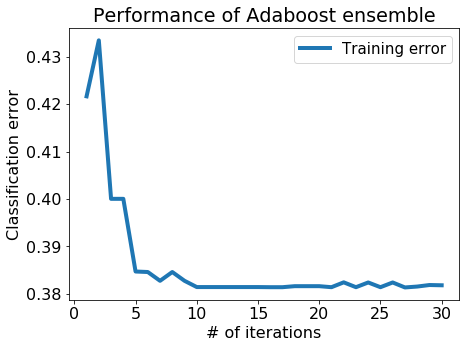

In [63]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})

In [64]:
stump_weights_test,tree_stumps_test=adaboost_with_tree_stumps(test_data,features,target,30)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (9284 data points).
Split on feature term_ 36 months. (2322, 6962)
--------------------------------------------------------------------
Subtree, depth = 2 (2322 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (6962 data points).
Reached maximum depth. Stopping for now.
{'is_leaf': False, 'prediction': None, 'splitting_feature': 'term_ 36 months', 'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1}, 'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1}}
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (9284 data points).
Split on feature grade_A. (7992, 1292)
--------------------------------------------------------------------
Subtree, depth = 2 (7992 data points).
Reached maximum depth. Stop

Adaboost Iteration 11
--------------------------------------------------------------------
Subtree, depth = 1 (9284 data points).
Split on feature grade_F. (8874, 410)
--------------------------------------------------------------------
Subtree, depth = 2 (8874 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (410 data points).
Reached maximum depth. Stopping for now.
{'is_leaf': False, 'prediction': None, 'splitting_feature': 'grade_F', 'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1}, 'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1}}
Adaboost Iteration 12
--------------------------------------------------------------------
Subtree, depth = 1 (9284 data points).
Split on feature emp_length_10+ years. (6770, 2514)
--------------------------------------------------------------------
Subtree, depth = 2 (6770 data points).
Reached maximum depth. Stoppin

Adaboost Iteration 22
--------------------------------------------------------------------
Subtree, depth = 1 (9284 data points).
Split on feature grade_F. (8874, 410)
--------------------------------------------------------------------
Subtree, depth = 2 (8874 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (410 data points).
Reached maximum depth. Stopping for now.
{'is_leaf': False, 'prediction': None, 'splitting_feature': 'grade_F', 'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1}, 'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1}}
Adaboost Iteration 23
--------------------------------------------------------------------
Subtree, depth = 1 (9284 data points).
Split on feature emp_length_< 1 year. (8447, 837)
--------------------------------------------------------------------
Subtree, depth = 2 (8447 data points).
Reached maximum depth. Stopping 

In [65]:
from sklearn.metrics import accuracy_score
test_error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data)
    error = 1.0 - accuracy_score(test_data[target], predictions)
    test_error_all.append(error)
    print ("Iteration %s, test error = %s" % (n, test_error_all[n-1]))

Iteration 1, test error = 0.4233089185695821
Iteration 2, test error = 0.4284791038345541
Iteration 3, test error = 0.3981042654028436
Iteration 4, test error = 0.3981042654028436
Iteration 5, test error = 0.37990090478242133
Iteration 6, test error = 0.38000861697544164
Iteration 7, test error = 0.37925463162429984
Iteration 8, test error = 0.38000861697544164
Iteration 9, test error = 0.37925463162429984
Iteration 10, test error = 0.37796208530805686
Iteration 11, test error = 0.37796208530805686
Iteration 12, test error = 0.37796208530805686
Iteration 13, test error = 0.37796208530805686
Iteration 14, test error = 0.37796208530805686
Iteration 15, test error = 0.37796208530805686
Iteration 16, test error = 0.37817750969409736
Iteration 17, test error = 0.37817750969409736
Iteration 18, test error = 0.37785437311503667
Iteration 19, test error = 0.37785437311503667
Iteration 20, test error = 0.37785437311503667
Iteration 21, test error = 0.37817750969409736
Iteration 22, test error =

32

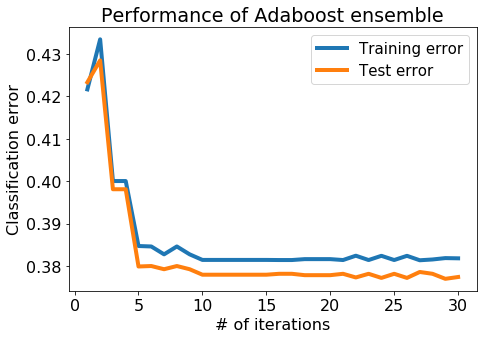

In [66]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()